<a href="https://colab.research.google.com/github/LindholmLabs/ContactBridge/blob/master/CS4287_Prj1_24293059_24273759_id3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lars Jacobs (24293059)
William Lindholm (24273759)
Patrick Vorreiter (24284335)



# Project 1 notes
-----------------

## Data Set

Skin cancer dataset. This dataset contains 1800 pictures of benign cell pictures and 1500 pictures of malignant cell pictures

## Pre-processing

This will be resizing and flipping the pictures randomly to improve the models generalization. Maybe grayscaling and exposure settings that can also be changed

## Network and hyperparameters

Probably this will be most work. Figuring out which network setup works best and makes most sense. Lots of research needed here to know what kind of layers and how big / how much of them to use.

## Loss Function

Try different loss functions and try to explain why some work better than others:
- MSE
- Cross entropy
- DICE


## Optimiser

Try different optimisers and try to explain why some work better than others:
- SGD
- ADAM


## Cross Fold Validation

Basically just use it, maybe 5 or 10 fold if needed

## Results

Display different kinds of metrics. For classification of our dataset we can use terms like FPR, TPR, precision, recall, accuracy, etc. Make a confusion matrix, stuff like that

## Evaluation

Try to see if we overfitted or underfitted the data. Not sure how to do this yet but we can figure it out.

## Experiments

Experiments with number of layers and what kind of layers for example. It will be crucial here to keep our notebook clean and make use of the code blocks in the notebook so we dont have to rerun all the code for different experiments.

**Loading the dataset**

In [ ]:
# Needed libraries
!pip install kaggle;

from google.colab import files

files.upload()

! mkdir ~/.kaggle;
! cp kaggle.json ~/.kaggle/;
! chmod 600 ~/.kaggle/kaggle.json;
! kaggle datasets list
!kaggle datasets download -d rm1000/skin-cancer-isic-images;
!unzip skin-cancer-isic-images.zip;



Saving kaggle.json to kaggle.json
ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                       Student Performance Factors                          94KB  2024-09-02 10:53:57          35194        622  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset   Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12           7041        125  1.0              
mohamedyosef101/2024-olympics-medals-and-economic-status      2024 Olympics Medals and Economic status              2KB  2024-10-13 12:39:58           1470         22  1.0              
abdulszz/spotify-most-streamed-songs

**Importing Data**

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path for your dataset
benign_path = './benign'
malignant_path = './malignant'

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        images.append(img)
    return images

# Load benign and malignant images
benign_images = load_images_from_folder(benign_path)
malignant_images = load_images_from_folder(malignant_path)


**Visualization**

In [ ]:
import numpy as np

def plot_pixel_intensity_distribution(images, title):
    intensities = []
    for img in images:
        img_array = np.array(img.convert('L'))  # Convert to grayscale
        intensities.extend(img_array.flatten())

    plt.hist(intensities, bins=50, color='purple', alpha=0.7)
    plt.title(f'{title} Image Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')
    plt.show()

# Plot pixel intensity distribution for benign and malignant images
plot_pixel_intensity_distribution(benign_images, "Benign")
plot_pixel_intensity_distribution(malignant_images, "Malignant")



# Our model class

--network structure
--Opimtizer
--Loss function
--Cross fold validation
--Explain what things we can change and which methods we will use for them

In [ ]:
from re import X
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ImageClassificationModel:
    def __init__(self, optimizer='adam', loss_function='binary_crossentropy', activation_function='relu', output_activation_function='sigmoid', num_output_neurons=1, batch_size=64, epochs=20, strides=(2, 2), dilation=(1, 1), data_augmentation=None):
        # Fixed parameters
        self.img_size = (228, 228)
        self.num_classes = 2
        self.test_size = 0.2
        self.val_size = 0.1

        # Customizable parameters
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.activation_function = activation_function
        self.batch_size = batch_size
        self.epochs = epochs
        self.output_activation_function = output_activation_function
        self.data_augmentation = data_augmentation
        self.model_summary = False
        self.training_progress = 0
        self.num_output_neurons = num_output_neurons
        self.strides = strides
        self.dilation = dilation

    def show_model_summary(self):
        self.model_summary = True

    def show_training_progress(self):
        self.training_progress = 1

    # Function to resize and normalize images
    def preprocess_images(self, images):
        images_resized = np.array([tf.image.resize(img, self.img_size).numpy() for img in images])
        images_resized = images_resized.astype('float32') / 255.0
        return images_resized

    # Function to load data, preprocess, and split into train, validation, and test sets
    def load_data(self, benign_images, malignant_images):
        benign_images_array = self.preprocess_images(benign_images)
        malignant_images_array = self.preprocess_images(malignant_images)

        benign_labels = np.zeros(len(benign_images_array))
        malignant_labels = np.ones(len(malignant_images_array))

        X_data = np.concatenate((benign_images_array, malignant_images_array), axis=0)
        y_data = np.concatenate((benign_labels, malignant_labels), axis=0)

        indices = np.arange(X_data.shape[0])
        np.random.shuffle(indices)
        X_data = X_data[indices]
        y_data = y_data[indices]

        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=self.test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=self.val_size, random_state=42)

        if self.num_output_neurons != 1:
            y_train = tf.keras.utils.to_categorical(y_train, self.num_classes)
            y_val = tf.keras.utils.to_categorical(y_val, self.num_classes)
            y_test = tf.keras.utils.to_categorical(y_test, self.num_classes)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # Function to build the model
    def build_model(self, input_shape):
        model = models.Sequential()

        # Input layer
        model.add(layers.Input(shape=input_shape))

        # 1st block
        model.add(layers.Conv2D(32, (3, 3), strides=self.stride, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.2))

        # 2nd block
        model.add(layers.Conv2D(64, (3, 3), strides=self.stride, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3, 3), strides=self.stride, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.3))

        # 3rd block
        model.add(layers.Conv2D(128, (3, 3), strides=self.stride, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3, 3), strides=self.stride, dilation_rate=self.dilation, padding='same', activation=self.activation_function))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.4))

        # Dense layer
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation=self.activation_function))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_output_neurons, activation=self.output_activation_function))

        return model

    # Function to compile and train the model using the preset parameters
    def train_model(self, X_train, y_train, X_val, y_val):
        model = self.build_model(X_train.shape[1:])

        model.compile(optimizer=self.optimizer, loss=self.loss_function, metrics=['accuracy'])

        if self.model_summary:
          model.summary()

        if self.data_augmentation:
          history = model.fit(self.data_augmentation.flow(X_train, y_train, batch_size=self.batch_size), epochs=self.epochs, validation_data=(X_val, y_val), verbose=self.training_progress)
        else:
          history = model.fit(X_train, y_train, batch_size=self.batch_size, epochs=self.epochs, validation_data=(X_val, y_val), verbose=self.training_progress)

        self.model = model
        return model, history

    # Function to evaluate the model on test data
    def evaluate_model(self, model, X_test, y_test):
        """Evaluates the model and prints performance metrics."""

        # For binary classification with sigmoid output:
        if self.num_output_neurons == 1:
            y_pred_prob = model.predict(X_test)
            y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions (0 or 1)
            y_true = y_test  # No need to use argmax for binary classification
        # For multi-class classification with softmax output:
        else:
            y_pred_prob = model.predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            y_true = np.argmax(y_test, axis=1)

        # Calculate the metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Print the results
        print(f"\nTest loss: {model.evaluate(X_test, y_test, verbose=0)[0]}")  # Keep original loss printing
        print(f"Test accuracy: {accuracy}")
        print(f"Test precision: {precision}")
        print(f"Test recall: {recall}")
        print(f"Test F1 score: {f1}")

        return accuracy, precision, recall, f1  # Return all metrics

    def run(self, evaluate_model=True, plot_history=True, print_confusion_matrix=True):
      X_train, y_train, X_val, y_val, X_test, y_test = self.load_data(benign_images, malignant_images)

      # Train the model
      model, history = self.train_model(X_train, y_train, X_val, y_val)

      if evaluate_model:
        # Evaluate the model on the test data
        self.evaluate_model(model, X_test, y_test)

      if plot_history:
        # Plot the training history
        self.plot_history(history)

      if print_confusion_matrix:
        # Print confusion matrix
        self.print_confusion_matrix(model, X_test, y_test)


    # Function to plot training and validation accuracy and loss
    def plot_history(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()



    def print_confusion_matrix(self, model, X_test, y_test):
        """Prints the confusion matrix."""
        if self.num_output_neurons == 1:  # Check if binary classification
            y_pred_prob = model.predict(X_test)
            y_pred = (y_pred_prob > 0.5).astype(int)  # Binary predictions (0 or 1)
            y_true = y_test  # No need to use argmax for binary classification
        else:
            y_pred_prob = model.predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            y_true = np.argmax(y_test, axis=1)

        conf_matrix = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


#**Results**

-Include results of varying paramters

Here is the default configuration that we got from the lab.

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.7156 - loss: 0.8960 - val_accuracy: 0.5871 - val_loss: 0.6352
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7573 - loss: 0.5656 - val_accuracy: 0.6174 - val_loss: 0.6345
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7547 - loss: 0.5219 - val_accuracy: 0.4773 - val_loss: 0.7720
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7737 - loss: 0.4243 - val_accuracy: 0.4545 - val_loss: 1.0895
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7957 - loss: 0.4040 - val_accuracy: 0.8068 - val_loss: 0.4109
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8021 - loss: 0.3925 - val_accuracy: 0.7311 - val_loss: 0.5411
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8051 - loss: 0.3926 - val_accuracy: 0.8220 - val_loss: 0.3631
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8232 - loss: 0.3664 - val_accuracy: 0.8068 - 

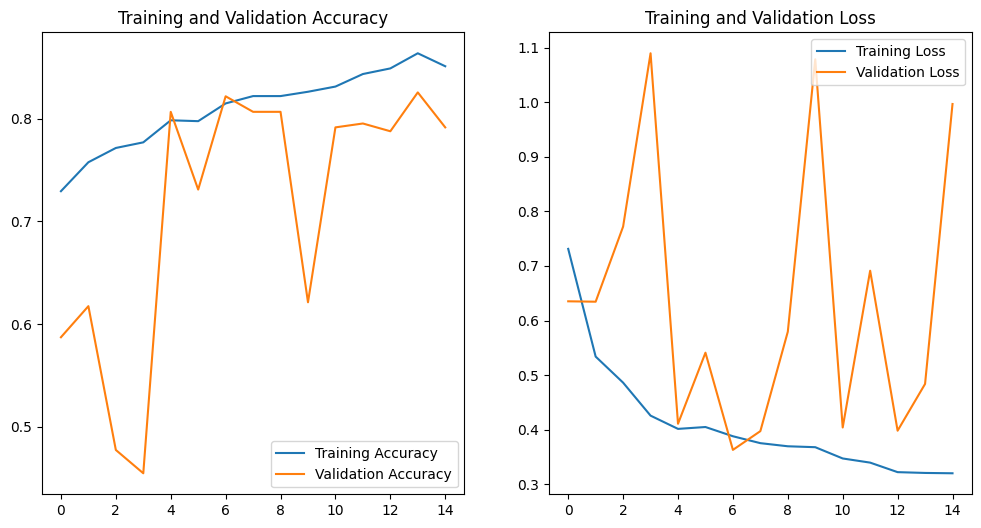

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


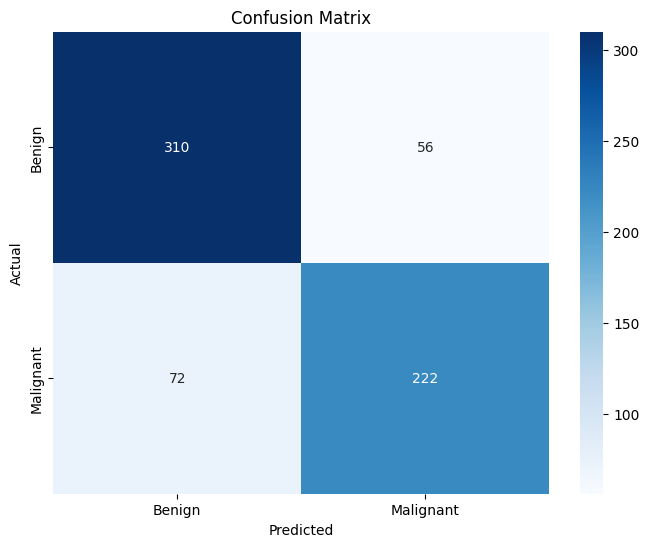

In [ ]:
model_obj = ImageClassificationModel(optimizer='RMSprop', loss_function='categorical_crossentropy', activation_function='relu', output_activation_function='softmax', batch_size=32, epochs=15, num_output_neurons=2)

model_obj.show_training_progress()
model_obj.run()

**Pre Processing Testing**

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 309ms/step - accuracy: 0.6746 - loss: 0.7990 - val_accuracy: 0.7235 - val_loss: 0.6676
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.7517 - loss: 0.5030 - val_accuracy: 0.6174 - val_loss: 0.6556
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.7597 - loss: 0.4789 - val_accuracy: 0.4886 - val_loss: 0.6921
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.7779 - loss: 0.4482 - val_accuracy: 0.7159 - val_loss: 0.5731
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.8047 - loss: 0.4120 - val_accuracy: 0.6932 - val_loss: 0.5282
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.8007 - loss: 0.3968 - val_accuracy: 0.7992 - val_loss: 0.4039
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.8116 - loss: 0.3837 - val_accuracy: 0.8106 - val_loss: 0.4346
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.8267 - loss: 0.3559 - val_accuracy: 0.787

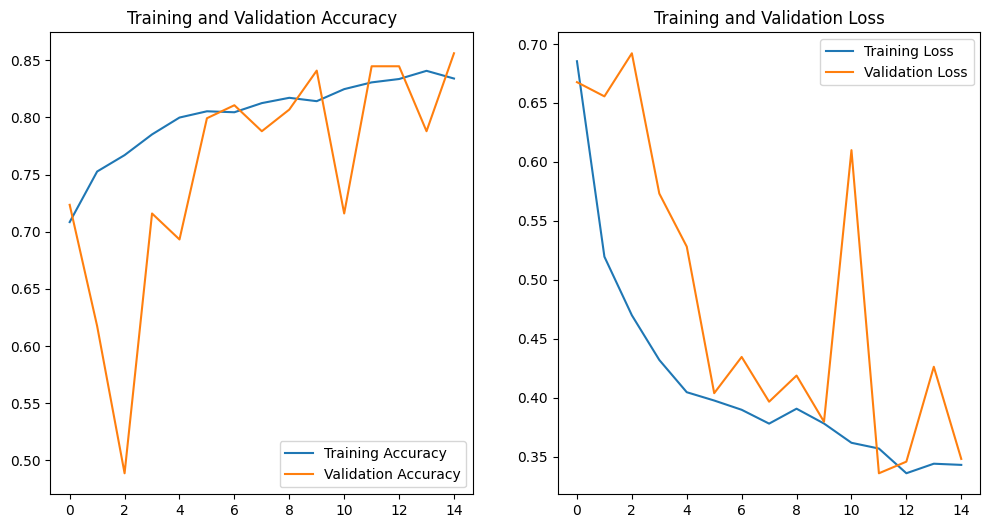

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


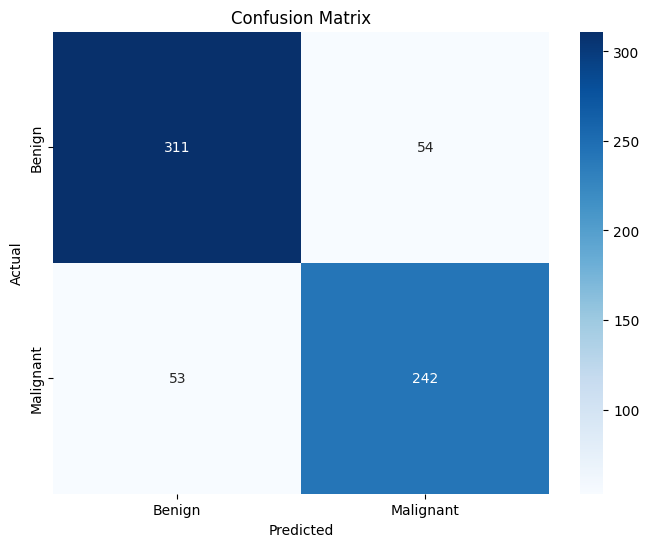

In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

model_obj = ImageClassificationModel(
    optimizer='adam',
    loss_function='binary_crossentropy',
    activation_function='relu',
    output_activation_function='sigmoid',
    batch_size=32, epochs=15,
    data_augmentation=datagen,
    num_output_neurons=1)

model_obj.show_training_progress()
model_obj.run()

#

#**Evaluation of results**